In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [ ]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices

    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]

    # Pivot as before
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the original selection order
    pivoted = pivoted.loc[selected_cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = [3, 13, 15, 81, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
list_cell_lines = [3, 13, 81, 25, 54, 74, 97, 40]
list_cell_lines = [3, 13, 81]
# list_cell_lines = range(64)
# list_cell_lines = [11, 81, 32]
x, Y = preprocess_data(df, list_cell_lines)

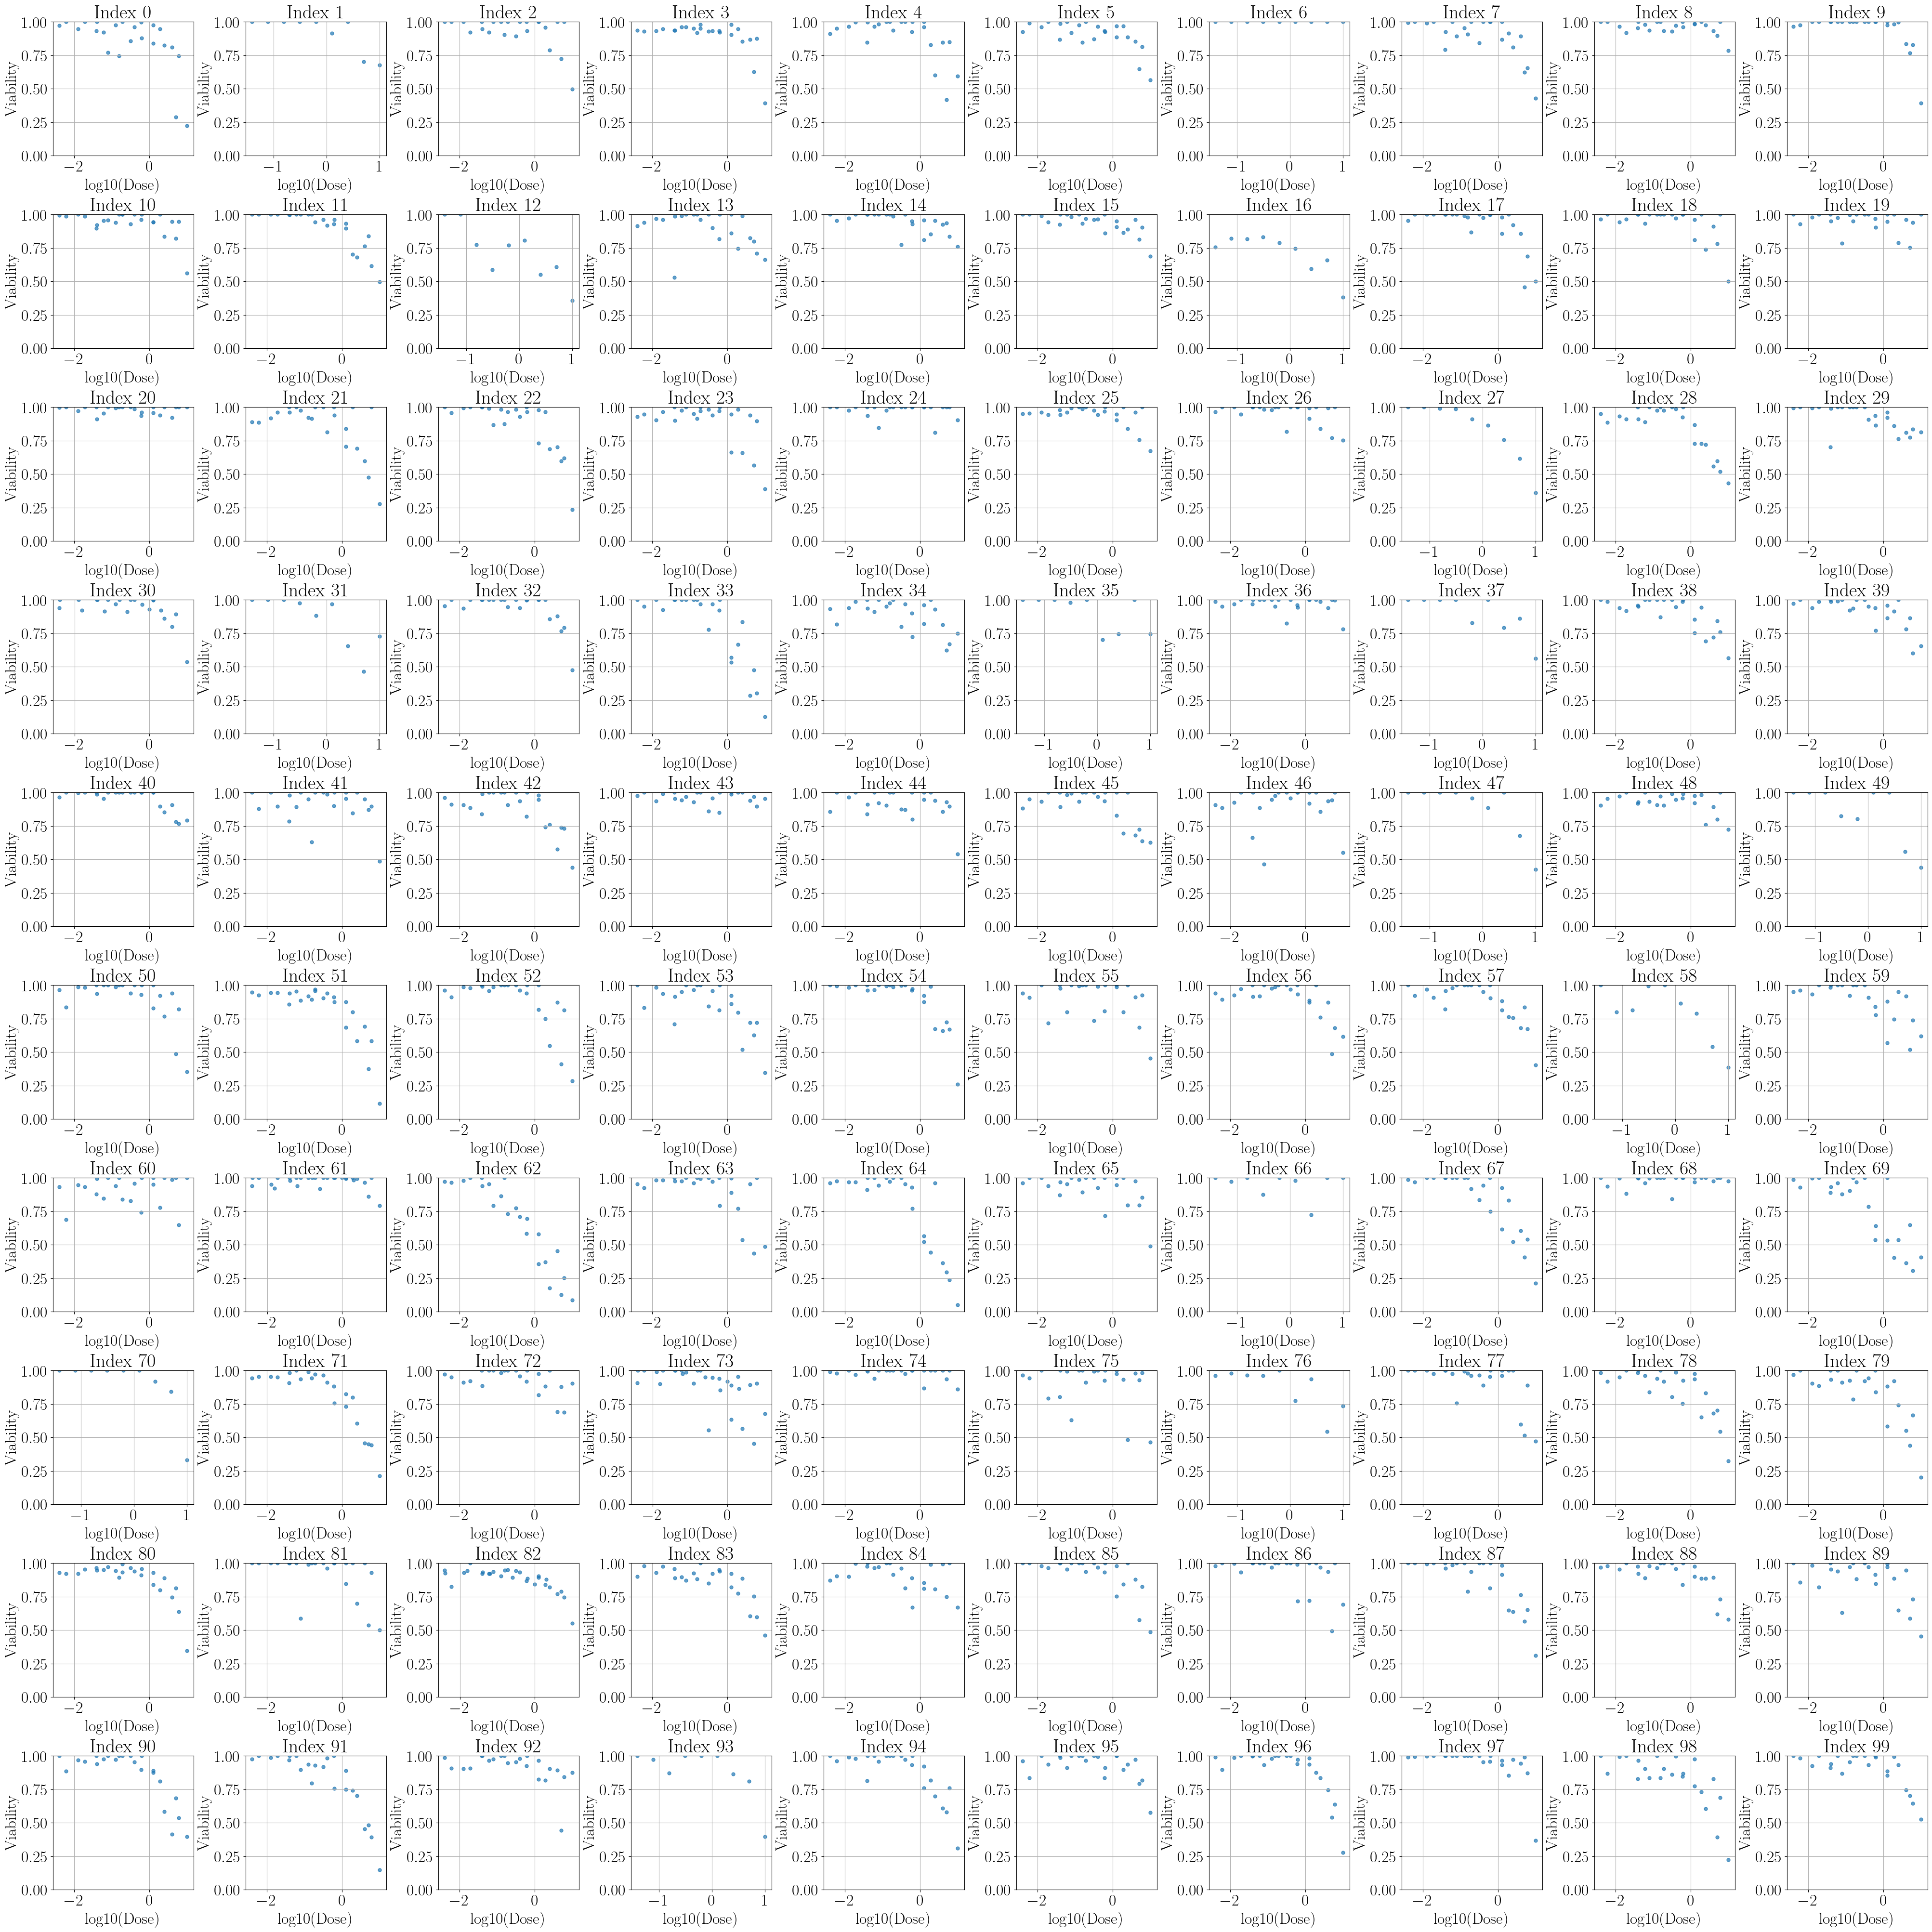

In [18]:
def visual_examples(df, k):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 100)

In [10]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

## MOGP

Optimized length_scale: 1.9672, noise: 0.005846
Optimized A: [[0.68249264 0.7241043  0.61223566]
 [0.50748735 0.45702701 0.48829978]
 [0.66378601 0.67845644 0.60592976]
 [0.44983788 0.33054407 0.46311456]
 [0.97260992 1.16689374 0.81767019]
 [0.29247251 0.05944761 0.36423589]
 [0.66712026 0.65701345 0.61906704]
 [0.52374478 0.43454314 0.51902434]]
Optimized B: 
[[1.36495574 0.97624614 1.31527409 0.82989467 2.00935873 0.4656548
  1.31006585 0.98987172]
 [0.97624614 0.70485378 0.94281129 0.60549334 1.42615736 0.35345157
  0.94111829 0.71783128]
 [1.31527409 0.94281129 1.26806588 0.80347074 1.93274213 0.45517314
  1.26369125 0.95696534]
 [0.82989467 0.60549334 0.80347074 0.52608859 1.20190155 0.31989821
  0.80396682 0.61960363]
 [2.00935873 1.42615736 1.93274213 1.20190155 2.97619559 0.65165553
  1.92170533 1.44085577]
 [0.4656548  0.35345157 0.45517314 0.31989821 0.65165553 0.22174197
  0.45965865 0.36806079]
 [1.31006585 0.94111829 1.26369125 0.80396682 1.92170533 0.45965865
  1.2599601

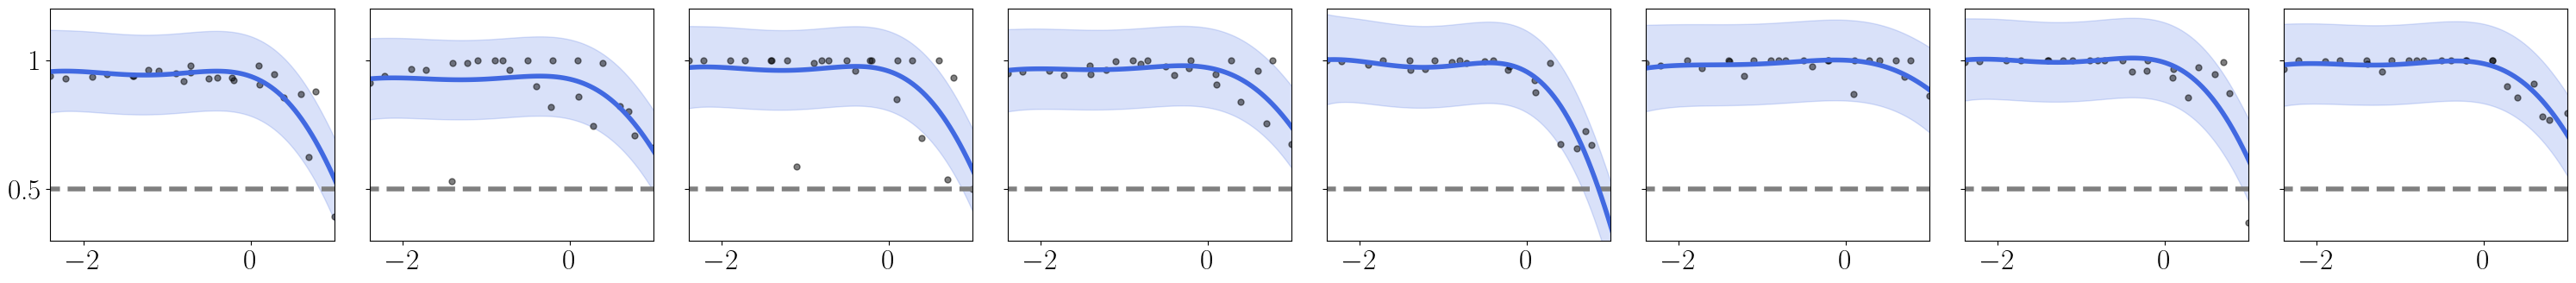

In [11]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = 0.1
init_A = generate_A(d=n_outputs, r=3, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_A = mogp.A
optim_B = mogp.B

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

IndexError: index 3 is out of bounds for axis 1 with size 3

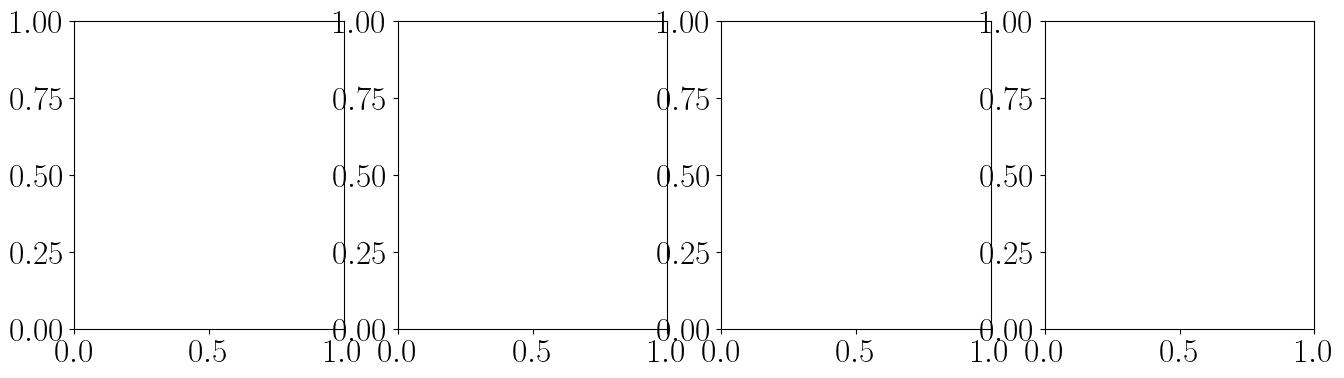

In [7]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # Dynamically adjust figure size

for i, j in enumerate([3, 13, 15, 41]):
    axs[i].plot(x.flatten(), Y[:, j], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu[:, j], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, j] - 2*std[:, j], mu[:, j] + 2*std[:, j], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

## MORCGP

218.69493044203753
218.6949304093885
218.69493006912515
218.6949301764523
218.6949308383939
218.69492992859622
218.69493058796314
218.6949301813531
218.69493074134996
218.69493099120905
218.69492972374692
218.694931462373
218.69493027930946
218.6949307027896
218.69493012013567
218.6949303898043
218.69493054487535
218.6949303309849
218.69493053559407
218.69493026649312
218.69493063764935
218.69493023691024
218.69493062894912
218.69493009407438
218.69493042017547
218.6949305211402
218.69493038083164
74.30140170695736
74.30140170227136
74.30140166545698
74.30140177204517
74.301401786435
74.30140176170919
74.30140182606108
74.3014019059361
74.30140181441767
74.30140150553254
74.30140150134797
74.30140148433979
74.30140190211387
74.30140192233488
74.30140192065836
74.30140131442413
74.30140131600312
74.30140128265539
74.30140194212814
74.30140191950866
74.30140196496507
74.30140199095642
74.30140197225278
74.3014020133617
74.30140200634308
74.30140193768621
74.30140207246033
187.51974201198

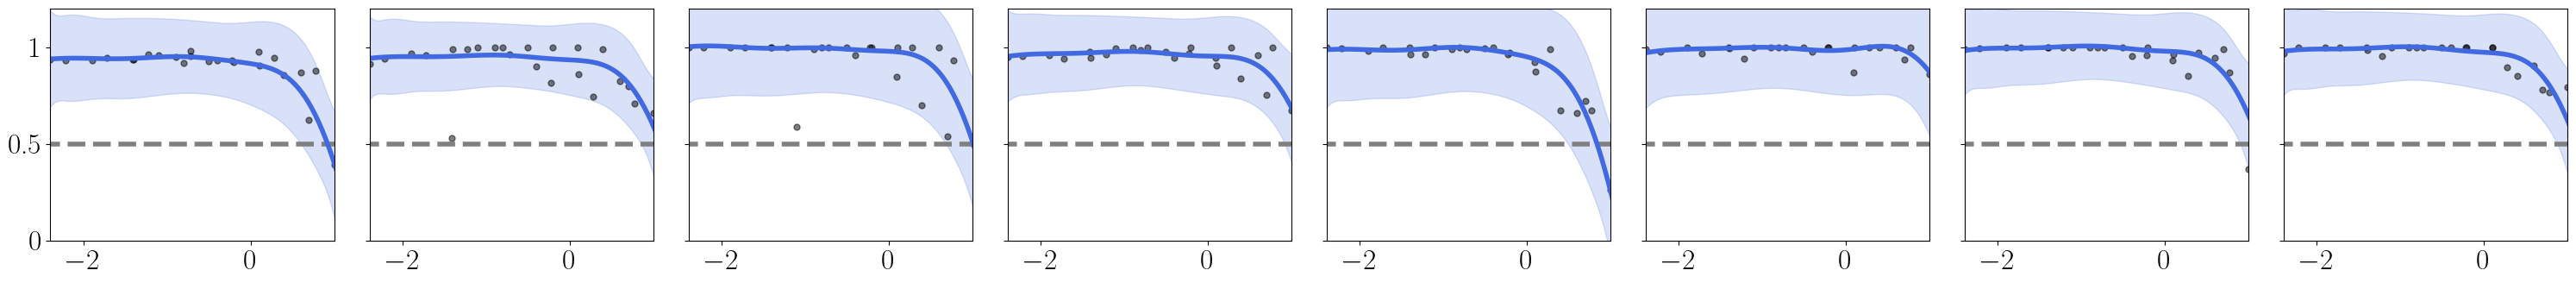

In [12]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = 0.004898
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
morcgp = MORCGPRegressor(n_outputs = n_outputs, mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y)

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

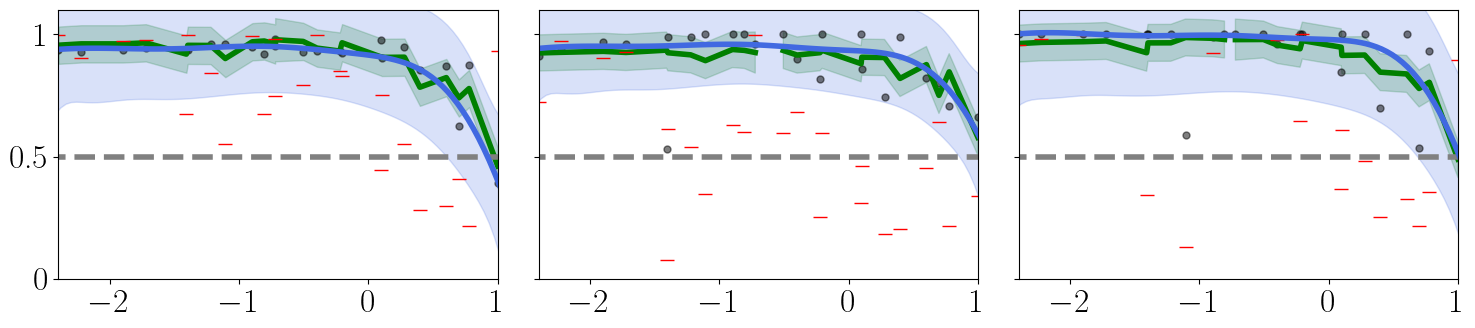

In [13]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(4 * 4, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='green', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + np.sqrt(predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), ((morcgp.w.reshape(n_outputs,-1).T/(morcgp.noise/2)**0.5))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.9, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

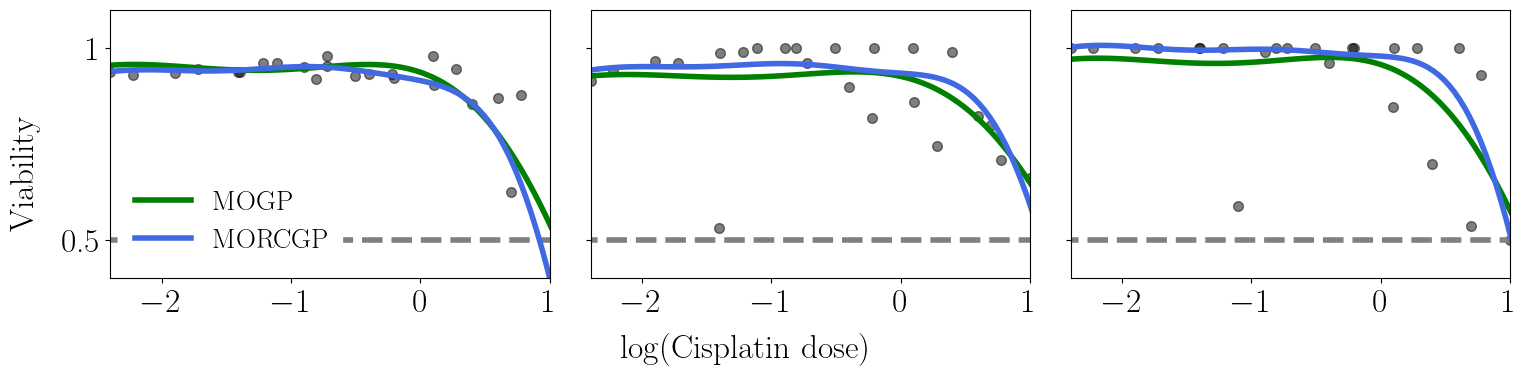

In [ ]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5, markersize=7)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    axs[i].set_ylim([0.4, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
        legend = axs[i].legend(loc='lower left', frameon=True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('white')
        frame.set_alpha(1.0)  # Fully opaque
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# Common axis labels
fig.text(0.5, 0.04, r'$\log(\textrm{Cisplatin dose})$', ha='center', fontsize=24)
fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

# fig.savefig("./cisplatin_MOGP.pdf", format='pdf', bbox_inches='tight')